In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

import missingno as msno
import seaborn as sns


warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

INPUT_PATH = '../../input/'

In [2]:
# parquet 불러오기

test = pd.read_parquet(INPUT_PATH + 'test.parquet')
train = pd.read_parquet(INPUT_PATH + 'train.parquet')

train

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296941,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,None,None,tunic.capitol_2.hall,None,0,0,1,13-22
26296942,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22
26296943,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,None,None,tunic.capitol_2.hall,None,0,0,1,13-22
26296944,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,None,chap4_finale_c,tunic.capitol_2.hall,None,0,0,1,13-22


In [3]:
targets = pd.read_csv(INPUT_PATH + 'train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
targets

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
...,...,...,...,...
424111,22100215342220508_q18,1,22100215342220508,18
424112,22100215460321130_q18,1,22100215460321130,18
424113,22100217104993650_q18,1,22100217104993650,18
424114,22100219442786200_q18,1,22100219442786200,18


In [4]:
%%time
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

df = (pl.read_parquet(INPUT_PATH + 'train.parquet')
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

CPU times: user 14.9 s, sys: 14.2 s, total: 29.1 s
Wall time: 18.3 s


parquet 으로 바꾸는게 훨씬 빠름 (캐글노트북 13.5s)

In [5]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']

event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

NUMS = [ 
    'page', 
    'room_coor_x', 
    'room_coor_y', 
    'screen_coor_x', 
    'screen_coor_y', 
    'hover_duration', 
    'elapsed_time_diff'
]

In [6]:
def feature_engineer(x, grp, use_extra, feature_suffix):
        
    aggs = [
        ## mean, min, max 
        ## 유니크 피쳐 수, 숫자형의 최대, 최소, 평균, 같은 이벤트 사이의 최대최소평균 시간
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name")==c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in name_feature],
    ]


    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    
    # bingo features
    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [7]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print('df1 done')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print('df2 done')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print('df3 done')

df1 done
df2 done
df3 done
CPU times: user 20.7 s, sys: 3.43 s, total: 24.1 s
Wall time: 8.69 s


세션 당 모든 정보를 가지고 한 줄로 만들었다

In [8]:
df1.head()

,session_id,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,page_mean_,room_coor_x_mean_,room_coor_y_mean_,screen_coor_x_mean_,screen_coor_y_mean_,hover_duration_mean_,elapsed_time_diff_mean_,page_min_,room_coor_x_min_,room_coor_y_min_,screen_coor_x_min_,screen_coor_y_min_,hover_duration_min_,elapsed_time_diff_min_,page_max_,room_coor_x_max_,room_coor_y_max_,screen_coor_x_max_,screen_coor_y_max_,hover_duration_max_,elapsed_time_diff_max_,cutscene_click_ET_mean_,person_click_ET_mean_,navigate_click_ET_mean_,observation_click_ET_mean_,notification_click_ET_mean_,object_click_ET_mean_,object_hover_ET_mean_,map_hover_ET_mean_,map_click_ET_mean_,checkpoint_ET_mean_,notebook_click_ET_mean_,cutscene_click_ET_max_,person_click_ET_max_,navigate_click_ET_max_,observation_click_ET_max_,notification_click_ET_max_,object_click_ET_max_,object_hover_ET_max_,map_hover_ET_max_,map_click_ET_max_,checkpoint_ET_max_,notebook_click_ET_max_,cutscene_click_ET_min_,person_click_ET_min_,navigate_click_ET_min_,observation_click_ET_min_,notification_click_ET_min_,object_click_ET_min_,object_hover_ET_min_,map_hover_ET_min_,map_click_ET_min_,checkpoint_ET_min_,notebook_click_ET_min_,basic_ET_mean_,undefined_ET_mean_,close_ET_mean_,open_ET_mean_,prev_ET_mean_,next_ET_mean_,basic_ET_max_,undefined_ET_max_,close_ET_max_,open_ET_max_,prev_ET_max_,next_ET_max_,basic_ET_min_,undefined_ET_min_,close_ET_min_,open_ET_min_,prev_ET_min_,next_ET_min_
0,20090312431273200,165,10,3,31,7,18,NaN,7.701275,-71.413749,93.550336,61.087248,2389.500000,1184.993939,NaN,-1013.383354,-307.773139,0.0,0.0,17.0,0,NaN,955.515258,416.026789,785.0,435.0,7899.0,30837,970.714286,917.590909,904.172840,1151.25,1821.75,1799.000000,170.0,771.0,675.000000,30837.0,NaN,2580,1774,2766,1452.0,4540,4949,517.0,1835.0,734,30837.0,NaN,0,0,0,901.0,208,533,0.0,132.0,616,30837.0,NaN,1507.486486,885.164706,1455.166667,NaN,NaN,NaN,30837,2766,2188,NaN,NaN,NaN,0,0,533,NaN,NaN,NaN
1,20090312433251036,139,11,4,23,6,12,0.0,-84.045960,-53.671082,90.788618,58.853659,1378.750000,1682.906475,0.0,-1112.320519,-518.582269,0.0,0.0,17.0,0,0.0,934.369987,441.012570,759.0,581.0,5567.0,37409,1515.194444,1928.444444,1419.857143,2259.00,1617.40,810.733333,1002.6,729.0,883.333333,37409.0,1533.5,8780,7984,7281,2716.0,1833,1901,3035.0,1070.0,1283,37409.0,2049.0,0,203,352,1802.0,1489,0,268.0,436.0,651,37409.0,1018.0,1959.116883,1356.303571,1014.000000,2049.0,NaN,NaN,37409,7281,1114,2049.0,NaN,NaN,0,268,901,2049.0,NaN,NaN
2,20090312455206810,149,9,3,23,6,13,NaN,-209.830316,-31.125035,83.978723,37.510638,3145.666667,2450.959732,NaN,-1017.030893,-240.402154,0.0,0.0,51.0,0,NaN,875.079107,450.472504,1149.0,644.0,8401.0,209421,601.938776,474.722222,4684.929825,NaN,2002.00,881.800000,568.0,1057.5,924.500000,28744.0,NaN,5767,3785,209421,NaN,6354,2166,568.0,1435.0,1501,28744.0,NaN,0,199,0,NaN,383,248,568.0,680.0,348,28744.0,NaN,1080.202381,4490.966667,999.600000,NaN,NaN,NaN,28744,209421,2021,NaN,NaN,NaN,0,0,248,NaN,NaN,NaN
3,20090313091715820,176,11,4,25,6,15,0.0,-111.962727,-76.698109,80.800000,72.443750,1917.142857,1110.056818,0.0,-995.609064,-431.727187,0.0,0.0,216.0,0,0.0,955.165697,455.432217,936.0,708.0,5794.0,47849,688.147059,591.318182,839.962500,1590.00,1298.00,940.111111,1266.6,1201.0,1091.500000,47849.0,1257.0,4784,2050,8160,2465.0,3301,3753,4547.0,1434.0,1651,47849.0,1512.0,0,0,0,715.0,0,199,218.0,968.0,532,47849.0,1002.0,1364.464286,879.729412,829.333333,1002.0,NaN,NaN,47849,8160,1512,1002.0,NaN,NaN,0,0,299,1002.0,NaN,NaN
4,20090313571836404,112,10,4,23,6,13,0.0,-5.028427,-1.624746,180.690722,96.711340,1580.714286,1748.883929,0.0,-918.020665,-486.344229,0.0,0.0,16.0,0,0.0,880.694812,484.995333,836.0,558.0,4383.0,31920,1415.615385,1230.578947,1532.457143,NaN,1648.50,2242.777778,1155.0,209.0,922.000000,31920.0,1950.0,3333,2751,4933,NaN,3684,8455,2751.0,300.0,1600,31920.0,3064.0,0,732,0,NaN,700,433,229.0,118.0,549,31920.0,853.0,1798.500000,1482.050000,2764.250000,1486.0,NaN,NaN,

In [9]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(df2.columns):
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(df3.columns):
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

6 3 0


100%|██████████| 79/79 [00:00<00:00, 1469.70it/s]


elapsed_time_diff_min_
*********df1 DONE*********


100%|██████████| 85/85 [00:00<00:00, 3217.22it/s]


elapsed_time_diff_min_
navigate_click_ET_min_
undefined_ET_min_
*********df2 DONE*********


100%|██████████| 83/83 [00:00<00:00, 3208.58it/s]

elapsed_time_diff_min_
navigate_click_ET_min_
undefined_ET_min_
*********df3 DONE*********


In [10]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [11]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 71 78 79 features
We will train with 23562 users info


In [13]:
df1

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,page_mean_,room_coor_x_mean_,room_coor_y_mean_,screen_coor_x_mean_,screen_coor_y_mean_,hover_duration_mean_,elapsed_time_diff_mean_,page_min_,room_coor_x_min_,room_coor_y_min_,screen_coor_x_min_,screen_coor_y_min_,hover_duration_min_,elapsed_time_diff_min_,page_max_,room_coor_x_max_,room_coor_y_max_,screen_coor_x_max_,screen_coor_y_max_,hover_duration_max_,elapsed_time_diff_max_,cutscene_click_ET_mean_,person_click_ET_mean_,navigate_click_ET_mean_,observation_click_ET_mean_,notification_click_ET_mean_,object_click_ET_mean_,object_hover_ET_mean_,map_hover_ET_mean_,map_click_ET_mean_,checkpoint_ET_mean_,notebook_click_ET_mean_,cutscene_click_ET_max_,person_click_ET_max_,navigate_click_ET_max_,observation_click_ET_max_,notification_click_ET_max_,object_click_ET_max_,object_hover_ET_max_,map_hover_ET_max_,map_click_ET_max_,checkpoint_ET_max_,notebook_click_ET_max_,cutscene_click_ET_min_,person_click_ET_min_,navigate_click_ET_min_,observation_click_ET_min_,notification_click_ET_min_,object_click_ET_min_,object_hover_ET_min_,map_hover_ET_min_,map_click_ET_min_,checkpoint_ET_min_,notebook_click_ET_min_,basic_ET_mean_,undefined_ET_mean_,close_ET_mean_,open_ET_mean_,prev_ET_mean_,next_ET_mean_,basic_ET_max_,undefined_ET_max_,close_ET_max_,open_ET_max_,prev_ET_max_,next_ET_max_,basic_ET_min_,undefined_ET_min_,close_ET_min_,open_ET_min_,prev_ET_min_,next_ET_min_
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,165,10,3,31,7,18,NaN,7.701275,-71.413749,93.550336,61.087248,2389.500000,1184.993939,NaN,-1013.383354,-307.773139,0.0,0.0,17.0,0,NaN,955.515258,416.026789,785.0,435.0,7899.0,30837,970.714286,917.590909,904.172840,1151.250000,1821.750000,1799.000000,170.000000,771.000000,675.000000,30837.0,NaN,2580,1774,2766,1452.0,4540,4949,517.0,1835.0,734,30837.0,NaN,0,0,0,901.0,208,533,0.0,132.0,616,30837.0,NaN,1507.486486,885.164706,1455.166667,NaN,NaN,NaN,30837,2766,2188,NaN,NaN,NaN,0,0,533,NaN,NaN,NaN
20090312433251036,139,11,4,23,6,12,0.000000,-84.045960,-53.671082,90.788618,58.853659,1378.750000,1682.906475,0.0,-1112.320519,-518.582269,0.0,0.0,17.0,0,0.0,934.369987,441.012570,759.0,581.0,5567.0,37409,1515.194444,1928.444444,1419.857143,2259.000000,1617.400000,810.733333,1002.600000,729.000000,883.333333,37409.0,1533.500000,8780,7984,7281,2716.0,1833,1901,3035.0,1070.0,1283,37409.0,2049.0,0,203,352,1802.0,1489,0,268.0,436.0,651,37409.0,1018.0,1959.116883,1356.303571,1014.000000,2049.000000,NaN,NaN,37409,7281,1114,2049.0,NaN,NaN,0,268,901,2049.0,NaN,NaN
20090312455206810,149,9,3,23,6,13,NaN,-209.830316,-31.125035,83.978723,37.510638,3145.666667,2450.959732,NaN,-1017.030893,-240.402154,0.0,0.0,51.0,0,NaN,875.079107,450.472504,1149.0,644.0,8401.0,209421,601.938776,474.722222,4684.929825,NaN,2002.000000,881.800000,568.000000,1057.500000,924.500000,28744.0,NaN,5767,3785,209421,NaN,6354,2166,568.0,1435.0,1501,28744.0,NaN,0,199,0,NaN,383,248,568.0,680.0,348,28744.0,NaN,1080.202381,4490.966667,999.600000,NaN,NaN,NaN,28744,209421,2021,NaN,NaN,NaN,0,0,248,NaN,NaN,NaN
20090313091715820,176,11,4,25,6,15,0.000000,-111.962727,-76.698109,80.800000,72.443750,1917.142857,1110.056818,0.0,-995.609064,-431.727187,0.0,0.0,216.0,0,0.0,955.165697,455.432217,936.0,708.0,5794.0,47849,688.147059,591.318182,839.962500,1590.000000,1298.000000,940.111111,1266.600000,1201.000000,1091.500000,47849.0,1257.000000,4784,2050,8160,2465.0,3301,3753,4547.0,1434.0,1651,47849.0,1512.0,0,0,0,715.0,0,199,218.0,968.0,532,47849.0,1002.0,1364.464286,879.729412,829.333333,1002.000000,NaN,NaN,47849,8160,1512,1002.0,NaN,NaN,0,0,299,1002.0,NaN,NaN
20090313571836404,112,10,4,23,6,13,0.000000,-5.028427,-1.624746,180.690722,96.711340,1580.714286,1748.883929,0.0,-918.020665,-486.344229,0.0,0.0,16.0,0,0.0,880.694812,484.995333,836.0,558.0,4383.0,31920,1415.615385,1230.578947,1532.457143,NaN,1648.500000,2242.777778,1155.000000,209.000000,922.

In [15]:
df1

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,page_mean_,room_coor_x_mean_,room_coor_y_mean_,screen_coor_x_mean_,screen_coor_y_mean_,hover_duration_mean_,elapsed_time_diff_mean_,page_min_,room_coor_x_min_,room_coor_y_min_,screen_coor_x_min_,screen_coor_y_min_,hover_duration_min_,elapsed_time_diff_min_,page_max_,room_coor_x_max_,room_coor_y_max_,screen_coor_x_max_,screen_coor_y_max_,hover_duration_max_,elapsed_time_diff_max_,cutscene_click_ET_mean_,person_click_ET_mean_,navigate_click_ET_mean_,observation_click_ET_mean_,notification_click_ET_mean_,object_click_ET_mean_,object_hover_ET_mean_,map_hover_ET_mean_,map_click_ET_mean_,checkpoint_ET_mean_,notebook_click_ET_mean_,cutscene_click_ET_max_,person_click_ET_max_,navigate_click_ET_max_,observation_click_ET_max_,notification_click_ET_max_,object_click_ET_max_,object_hover_ET_max_,map_hover_ET_max_,map_click_ET_max_,checkpoint_ET_max_,notebook_click_ET_max_,cutscene_click_ET_min_,person_click_ET_min_,navigate_click_ET_min_,observation_click_ET_min_,notification_click_ET_min_,object_click_ET_min_,object_hover_ET_min_,map_hover_ET_min_,map_click_ET_min_,checkpoint_ET_min_,notebook_click_ET_min_,basic_ET_mean_,undefined_ET_mean_,close_ET_mean_,open_ET_mean_,prev_ET_mean_,next_ET_mean_,basic_ET_max_,undefined_ET_max_,close_ET_max_,open_ET_max_,prev_ET_max_,next_ET_max_,basic_ET_min_,undefined_ET_min_,close_ET_min_,open_ET_min_,prev_ET_min_,next_ET_min_
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,165,10,3,31,7,18,NaN,7.701275,-71.413749,93.550336,61.087248,2389.500000,1184.993939,NaN,-1013.383354,-307.773139,0.0,0.0,17.0,0,NaN,955.515258,416.026789,785.0,435.0,7899.0,30837,970.714286,917.590909,904.172840,1151.250000,1821.750000,1799.000000,170.000000,771.000000,675.000000,30837.0,NaN,2580,1774,2766,1452.0,4540,4949,517.0,1835.0,734,30837.0,NaN,0,0,0,901.0,208,533,0.0,132.0,616,30837.0,NaN,1507.486486,885.164706,1455.166667,NaN,NaN,NaN,30837,2766,2188,NaN,NaN,NaN,0,0,533,NaN,NaN,NaN
20090312433251036,139,11,4,23,6,12,0.000000,-84.045960,-53.671082,90.788618,58.853659,1378.750000,1682.906475,0.0,-1112.320519,-518.582269,0.0,0.0,17.0,0,0.0,934.369987,441.012570,759.0,581.0,5567.0,37409,1515.194444,1928.444444,1419.857143,2259.000000,1617.400000,810.733333,1002.600000,729.000000,883.333333,37409.0,1533.500000,8780,7984,7281,2716.0,1833,1901,3035.0,1070.0,1283,37409.0,2049.0,0,203,352,1802.0,1489,0,268.0,436.0,651,37409.0,1018.0,1959.116883,1356.303571,1014.000000,2049.000000,NaN,NaN,37409,7281,1114,2049.0,NaN,NaN,0,268,901,2049.0,NaN,NaN
20090312455206810,149,9,3,23,6,13,NaN,-209.830316,-31.125035,83.978723,37.510638,3145.666667,2450.959732,NaN,-1017.030893,-240.402154,0.0,0.0,51.0,0,NaN,875.079107,450.472504,1149.0,644.0,8401.0,209421,601.938776,474.722222,4684.929825,NaN,2002.000000,881.800000,568.000000,1057.500000,924.500000,28744.0,NaN,5767,3785,209421,NaN,6354,2166,568.0,1435.0,1501,28744.0,NaN,0,199,0,NaN,383,248,568.0,680.0,348,28744.0,NaN,1080.202381,4490.966667,999.600000,NaN,NaN,NaN,28744,209421,2021,NaN,NaN,NaN,0,0,248,NaN,NaN,NaN
20090313091715820,176,11,4,25,6,15,0.000000,-111.962727,-76.698109,80.800000,72.443750,1917.142857,1110.056818,0.0,-995.609064,-431.727187,0.0,0.0,216.0,0,0.0,955.165697,455.432217,936.0,708.0,5794.0,47849,688.147059,591.318182,839.962500,1590.000000,1298.000000,940.111111,1266.600000,1201.000000,1091.500000,47849.0,1257.000000,4784,2050,8160,2465.0,3301,3753,4547.0,1434.0,1651,47849.0,1512.0,0,0,0,715.0,0,199,218.0,968.0,532,47849.0,1002.0,1364.464286,879.729412,829.333333,1002.000000,NaN,NaN,47849,8160,1512,1002.0,NaN,NaN,0,0,299,1002.0,NaN,NaN
20090313571836404,112,10,4,23,6,13,0.000000,-5.028427,-1.624746,180.690722,96.711340,1580.714286,1748.883929,0.0,-918.020665,-486.344229,0.0,0.0,16.0,0,0.0,880.694812,484.995333,836.0,558.0,4383.0,31920,1415.615385,1230.578947,1532.457143,NaN,1648.500000,2242.777778,1155.000000,209.000000,922.

In [22]:
# PCA - remove outlier
def pca_components(df, features):
    df_scaled = StandardScaler().fit_transform(df[features].dropna(axis=1))
    pcom = PCA(n_components=2).fit_transform(df_scaled)
    return pcom

# pca component having over 1.0 is removed as these might be outliers
pca1 = pca_components(df1, FEATURES1)
pca2 = pca_components(df2, FEATURES2)
pca3 = pca_components(df3, FEATURES3)

for i in range(1, 4):
    pc = pca_components(globals()['df'+str(i)], globals()['FEATURES'+str(i)])
    globals()['df'+str(i)]['pc1'] = pc[:, 0]
    globals()['df'+str(i)] = globals()['df'+str(i)].loc[globals()['df'+str(i)]['pc1'] < 1.0]


In [35]:
USERS_NOOUT = list(set(df1.index) & set(df2.index) & set(df3.index))
USERS_NOOUT.sort()

In [36]:
oof_xgb = pd.DataFrame(data=np.zeros((len(USERS_NOOUT),18)), index=USERS_NOOUT, columns=[f'meta_{i}' for i in range(1, 19)])
oof_xgb

,meta_1,meta_2,meta_3,meta_4,meta_5,meta_6,meta_7,meta_8,meta_9,meta_10,meta_11,meta_12,meta_13,meta_14,meta_15,meta_16,meta_17,meta_18
20090312431273200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090312433251036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090312455206810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090313091715820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20090313571836404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215241104530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22100215460321130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22100217104993650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22100219442786200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(USERS_NOOUT),18)), index=USERS_NOOUT, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    # outlier users removed    
    df = df.loc[USERS_NOOUT]

    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }

    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        # pdb.set_trace()
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL, PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
    

    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))

#########################
### question 1 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
checkpoint_ET_max_,0.061110
checkpoint_ET_min_,0.047545
session_number_,0.041010
checkpoint_ET_mean_,0.038701
room_fqid_unique_,0.036383
cutscene_click_ET_mean_,0.036348
object_click_ET_min_,0.030634
basic_ET_max_,0.029651
basic_ET_mean_,0.024868


#########################
### question 2 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.040810
object_click_ET_min_,0.034825
checkpoint_ET_max_,0.034705
checkpoint_ET_min_,0.033824
person_click_ET_min_,0.032005
checkpoint_ET_mean_,0.029705
cutscene_click_ET_mean_,0.022972
basic_ET_mean_,0.022636
basic_ET_max_,0.020056


#########################
### question 3 with features 71
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.040762
checkpoint_ET_max_,0.037503
checkpoint_ET_min_,0.036484
checkpoint_ET_mean_,0.032542
basic_ET_mean_,0.024514
cutscene_click_ET_mean_,0.022805
basic_ET_max_,0.022587
person_click_ET_mean_,0.021267
elapsed_time_diff_max_,0.018573


#########################
### question 4 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.078197
person_click_ET_min_,0.059248
text_fqid_unique_,0.051881
person_click_ET_mean_,0.049387
reader_bingo_indexCount,0.030078
page_max_,0.023843
room_fqid_unique_,0.023785
basic_ET_mean_,0.023580
cutscene_click_ET_min_,0.022597


#########################
### question 5 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.099186
text_fqid_unique_,0.064473
journals_bingo_indexCount,0.054460
person_click_ET_min_,0.023976
reader_bingo_indexCount,0.023568
observation_click_ET_max_,0.023505
person_click_ET_mean_,0.021656
journals_bingo_duration,0.021170
observation_click_ET_mean_,0.019579


#########################
### question 6 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.100720
text_fqid_unique_,0.070326
journals_bingo_indexCount,0.045340
reader_bingo_indexCount,0.034169
room_fqid_unique_,0.029440
journals_bingo_duration,0.021780
logbook_bingo_indexCount,0.019640
observation_click_ET_max_,0.019018
person_click_ET_min_,0.018588


#########################
### question 7 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.070447
text_fqid_unique_,0.053859
room_fqid_unique_,0.032797
journals_bingo_indexCount,0.028529
observation_click_ET_max_,0.023394
journals_bingo_duration,0.022928
reader_bingo_indexCount,0.021614
person_click_ET_min_,0.020624
hover_duration_mean_,0.020391


#########################
### question 8 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.054841
text_fqid_unique_,0.040908
journals_bingo_indexCount,0.027332
room_fqid_unique_,0.024180
observation_click_ET_max_,0.020603
fqid_unique_,0.019859
person_click_ET_mean_,0.017633
journals_bingo_duration,0.016998
observation_click_ET_mean_,0.016356


#########################
### question 9 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.088675
text_fqid_unique_,0.068123
journals_bingo_indexCount,0.035649
reader_bingo_indexCount,0.034455
room_fqid_unique_,0.028447
observation_click_ET_max_,0.020851
journals_bingo_duration,0.019406
person_click_ET_min_,0.019059
hover_duration_mean_,0.016393


#########################
### question 10 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.093489
journals_bingo_indexCount,0.049104
text_fqid_unique_,0.046429
journals_bingo_duration,0.028277
reader_bingo_indexCount,0.027316
observation_click_ET_max_,0.021017
person_click_ET_min_,0.020492
person_click_ET_mean_,0.019191
room_fqid_unique_,0.018797


#########################
### question 11 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.071131
journals_bingo_indexCount,0.041023
journals_bingo_duration,0.033586
observation_click_ET_max_,0.026381
reader_bingo_indexCount,0.025311
text_fqid_unique_,0.024944
room_fqid_unique_,0.021719
observation_click_ET_mean_,0.016722
hover_duration_min_,0.015077


#########################
### question 12 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.057881
text_fqid_unique_,0.031839
reader_bingo_indexCount,0.026184
person_click_ET_min_,0.022951
person_click_ET_mean_,0.019452
hover_duration_mean_,0.019382
observation_click_ET_max_,0.019195
room_fqid_unique_,0.018394
journals_bingo_indexCount,0.018087


#########################
### question 13 with features 78
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
journals_bingo_duration,0.071193
journals_bingo_indexCount,0.054507
reader_bingo_duration,0.049116
room_fqid_unique_,0.047964
session_number_,0.033944
fqid_unique_,0.029685
logbook_bingo_duration,0.026489
prev_ET_max_,0.015032
notification_click_ET_mean_,0.014658


#########################
### question 14 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
room_fqid_unique_,0.084164
session_number_,0.068926
text_fqid_unique_,0.058581
person_click_ET_min_,0.020251
person_click_ET_max_,0.018529
observation_click_ET_max_,0.018331
hover_duration_mean_,0.017698
cutscene_click_ET_mean_,0.017563
cutscene_click_ET_min_,0.017030


#########################
### question 15 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
room_fqid_unique_,0.094196
session_number_,0.063310
text_fqid_unique_,0.052637
observation_click_ET_max_,0.023009
person_click_ET_min_,0.022324
person_click_ET_max_,0.020708
cutscene_click_ET_mean_,0.019738
observation_click_ET_mean_,0.019624
person_click_ET_mean_,0.018518


#########################
### question 16 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
event_name_unique_,0.026443
session_number_,0.026283
room_fqid_unique_,0.020120
hover_duration_mean_,0.017008
person_click_ET_mean_,0.016984
journalsFlag_bingo_indexCount,0.016530
notification_click_ET_min_,0.016199
hover_duration_min_,0.015918
observation_click_ET_mean_,0.015219


#########################
### question 17 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
notification_click_ET_mean_,0.029887
basic_ET_mean_,0.028171
session_number_,0.025546
person_click_ET_mean_,0.023495
close_ET_mean_,0.023010
journalsFlag_bingo_duration,0.020091
close_ET_max_,0.019840
notification_click_ET_max_,0.017448
room_fqid_unique_,0.017078


#########################
### question 18 with features 79
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.047770
room_fqid_unique_,0.028291
person_click_ET_max_,0.024093
text_fqid_unique_,0.021439
close_ET_mean_,0.019370
observation_click_ET_max_,0.019234
cutscene_click_ET_mean_,0.017175
close_ET_max_,0.016188
person_click_ET_mean_,0.016162


CPU times: user 4min 7s, sys: 1.85 s, total: 4min 9s
Wall time: 1min 33s


0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

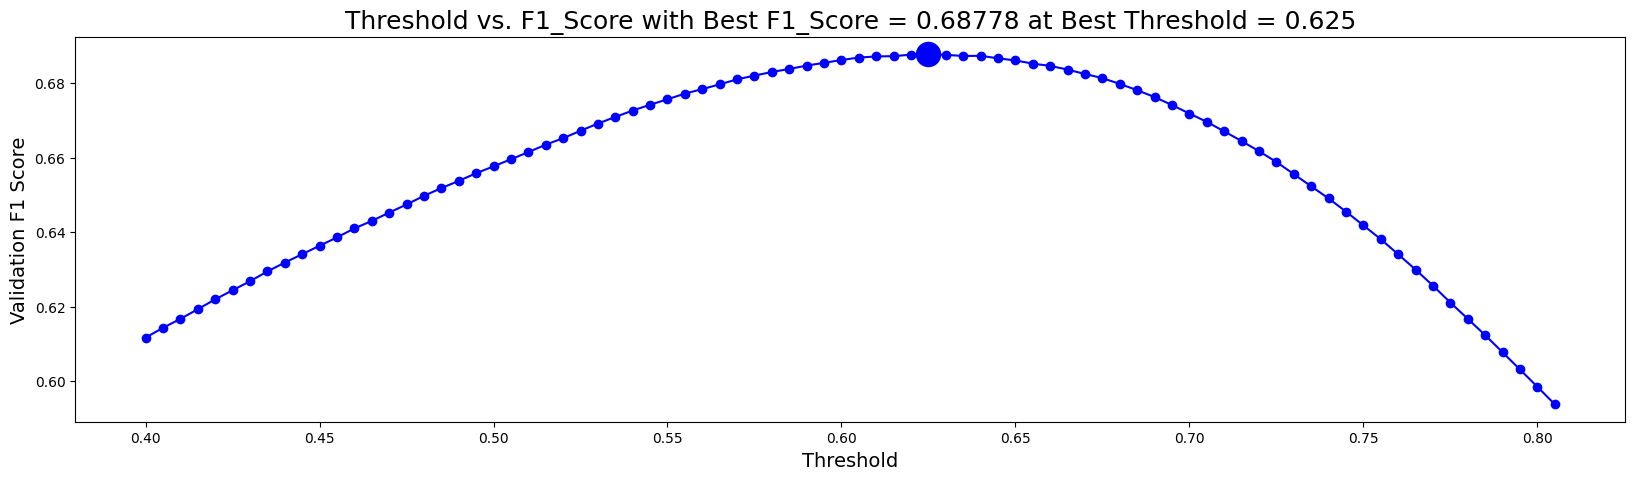

In [16]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

In [80]:
%%time
# ITERATE THRU QUESTIONS 1 THRU 18
dat_list = []
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'  # 
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.xgb')
    dat_list.append(df[FEATURES].astype('float32'))
    print()

#########################
### question 1 features 71

#########################
### question 2 features 71

#########################
### question 3 features 71

#########################
### question 4 features 78

#########################
### question 5 features 78

#########################
### question 6 features 78

#########################
### question 7 features 78

#########################
### question 8 features 78

#########################
### question 9 features 78

#########################
### question 10 features 78

#########################
### question 11 features 78

#########################
### question 12 features 78

#########################
### question 13 features 78

#########################
### question 14 features 79

#########################
### question 15 features 79

#########################
### question 16 features 79

#########################
### question 17 features 79

#########################
### question 18 features 79

CPU times: user 45.

결론 : 같은 그룹의 문제들을 똑같은 유저 기록으로 예측했다. 하지만 문제마다 모델을 다르게 두어 총 18개의 모델을 생성했다.  
여기에서 똑같은 유저 기록으로 다른 모델을 만드는게 아닌 유저 기록을 나누어서 학습하는 식으로 개선할 수 있을 것 같다. 

C1 C2 C3 ; TARGET
1 ~ 3 : FEATURES: C1 C2 C3 (M1 M2 M3) - Q1 - LOG Q2 - LOG Q3 - LOG 
79개 features - q1 corr, q2 corr, q3 corr /   

Q1 vs FEATURES  (CORR)  - feature를 선택 
Q2 VS FEATURES (CORR)




## PCA + K-means clustering

In [144]:
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import seaborn as sns


<Axes: >

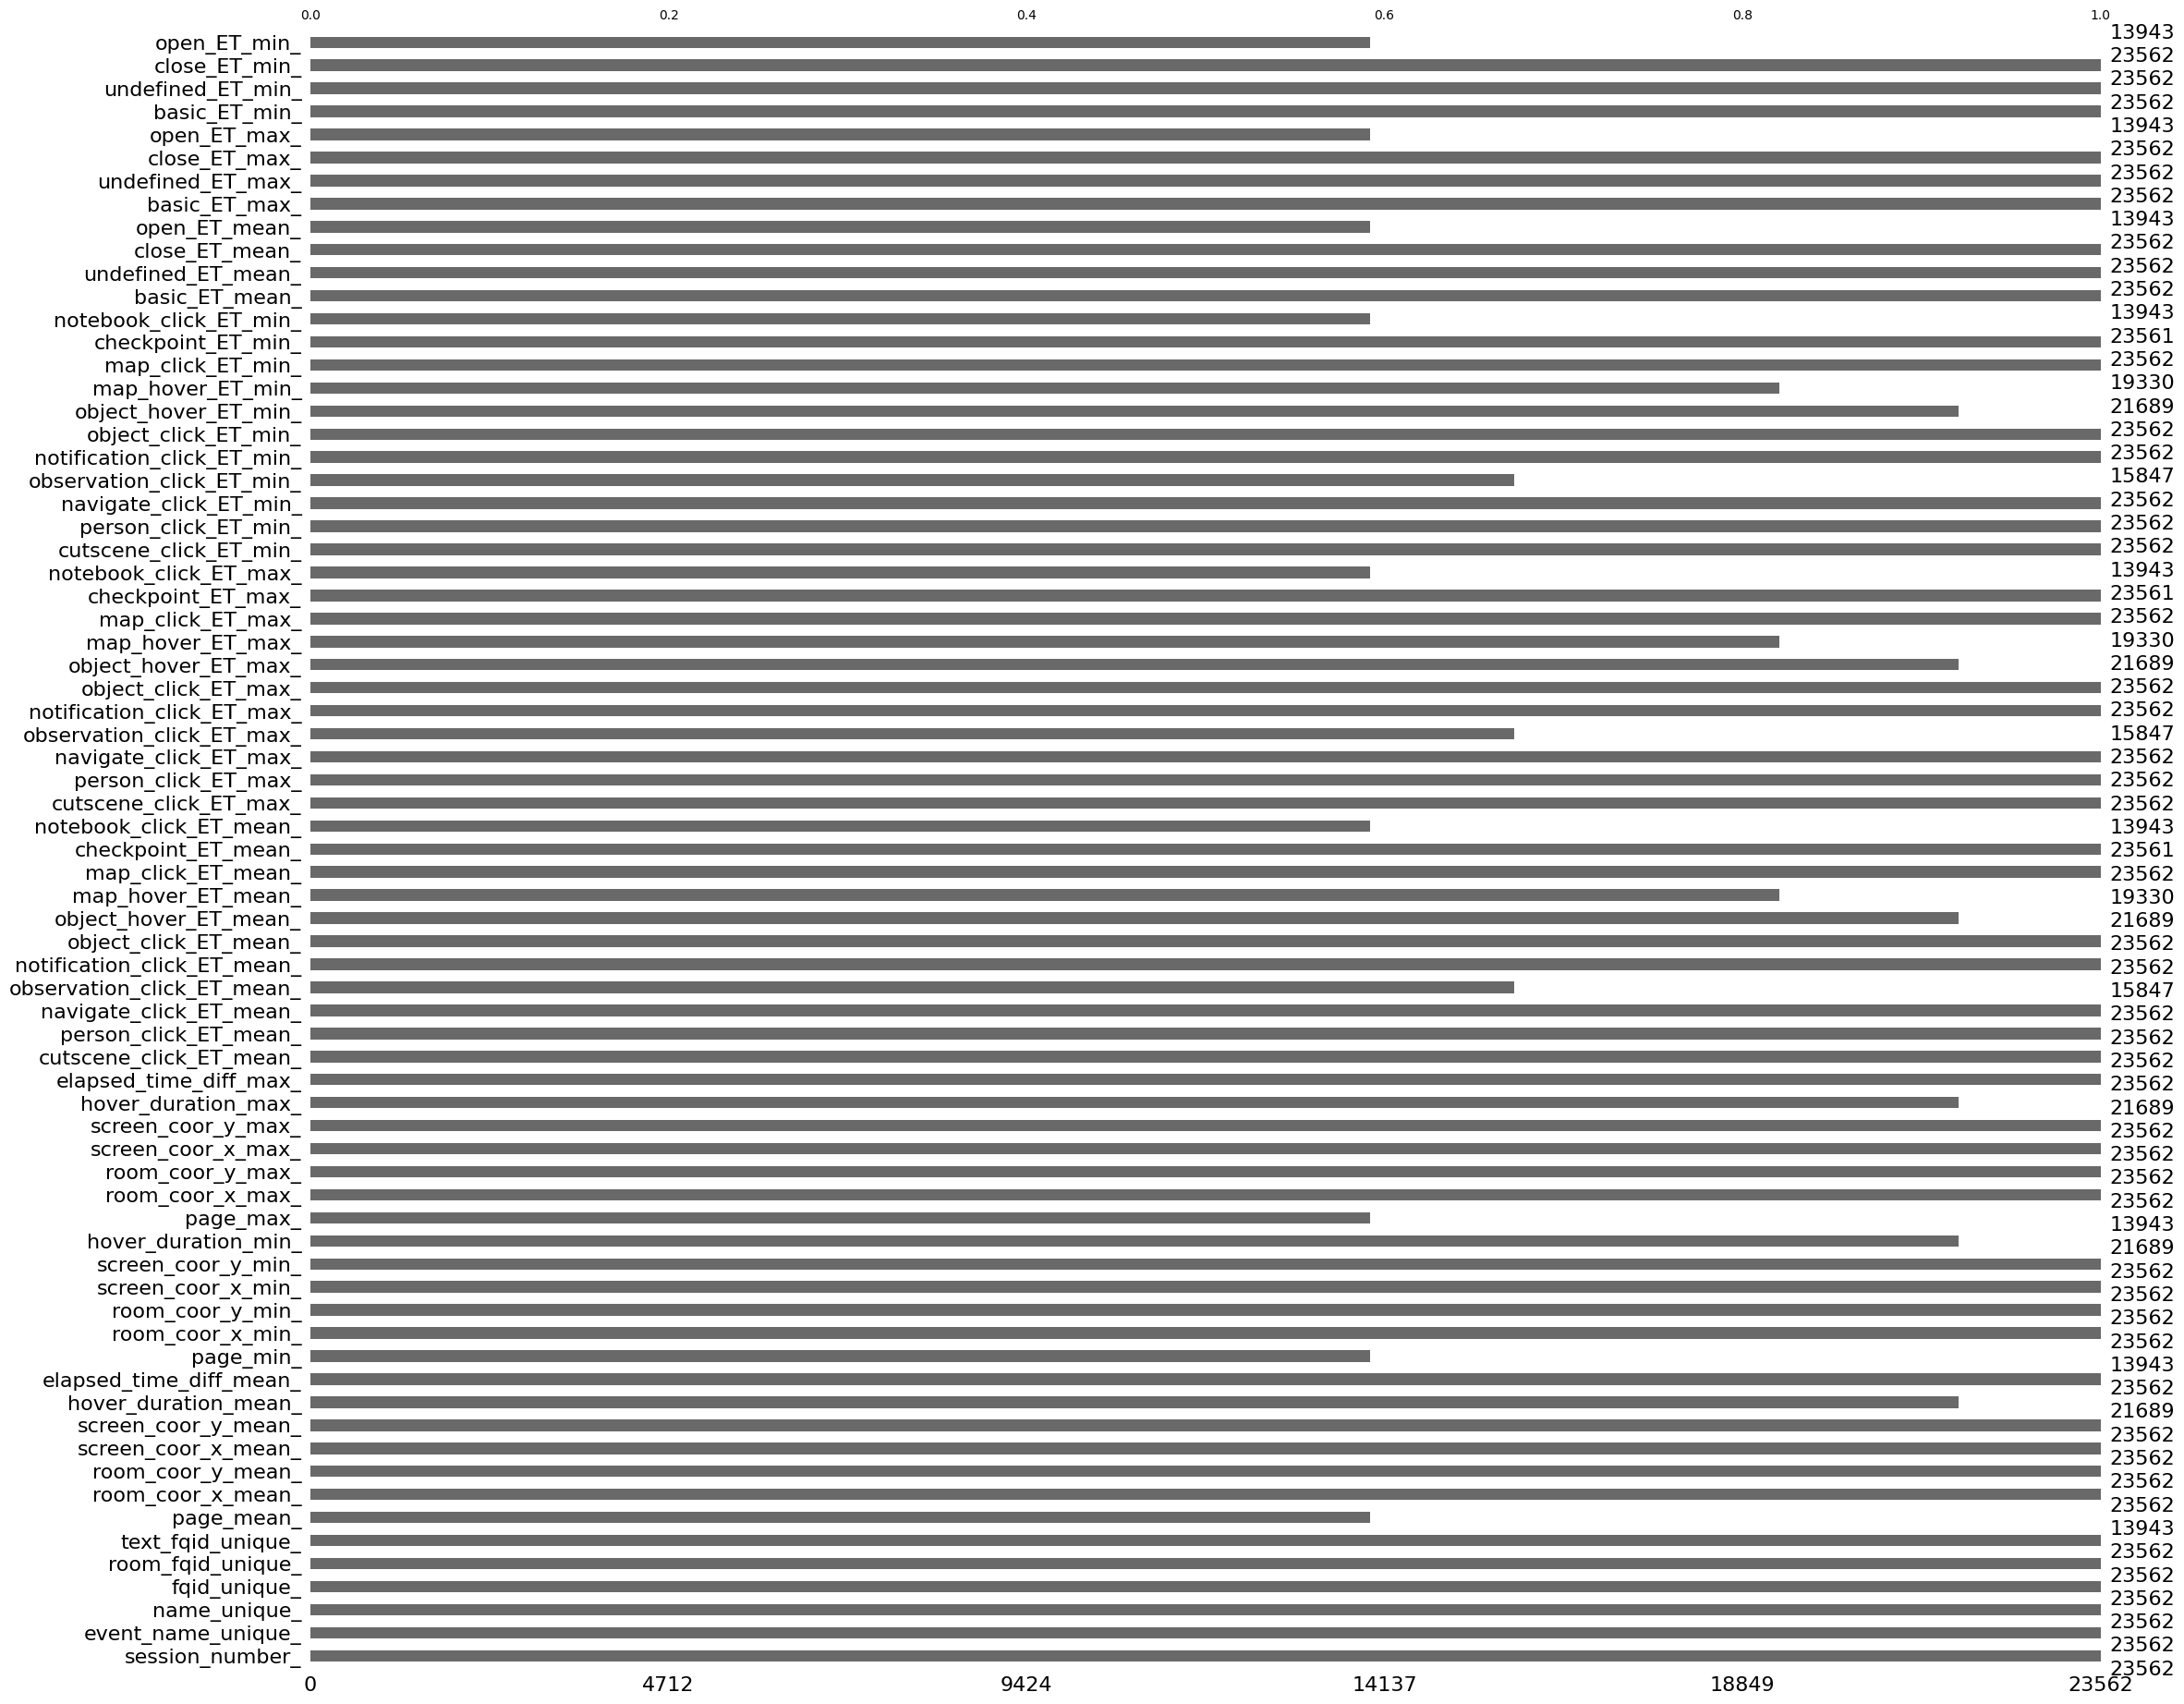

In [25]:
msno.bar(df1[FEATURES1])

In [ ]:
df1[FEATURES1].dropna(axis=1)
df1_scaled = StandardScaler().fit_transform(df1[FEATURES1].dropna(axis=1))

pcom = PCA(n_components=2).fit_transform(df1_scaled)

In [39]:
df1[FEATURES1].dropna(axis=1)

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,room_coor_x_mean_,room_coor_y_mean_,screen_coor_x_mean_,screen_coor_y_mean_,elapsed_time_diff_mean_,room_coor_x_min_,room_coor_y_min_,screen_coor_x_min_,screen_coor_y_min_,room_coor_x_max_,room_coor_y_max_,screen_coor_x_max_,screen_coor_y_max_,elapsed_time_diff_max_,cutscene_click_ET_mean_,person_click_ET_mean_,navigate_click_ET_mean_,notification_click_ET_mean_,object_click_ET_mean_,map_click_ET_mean_,cutscene_click_ET_max_,person_click_ET_max_,navigate_click_ET_max_,notification_click_ET_max_,object_click_ET_max_,map_click_ET_max_,cutscene_click_ET_min_,person_click_ET_min_,navigate_click_ET_min_,notification_click_ET_min_,object_click_ET_min_,map_click_ET_min_,basic_ET_mean_,undefined_ET_mean_,close_ET_mean_,basic_ET_max_,undefined_ET_max_,close_ET_max_,basic_ET_min_,undefined_ET_min_,close_ET_min_
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,165,10,3,31,7,18,7.701275,-71.413749,93.550336,61.087248,1184.993939,-1013.383354,-307.773139,0.0,0.0,955.515258,416.026789,785.0,435.0,30837,970.714286,917.590909,904.172840,1821.750000,1799.000000,675.000000,2580,1774,2766,4540,4949,734,0,0,0,208,533,616,1507.486486,885.164706,1455.166667,30837,2766,2188,0,0,533
20090312433251036,139,11,4,23,6,12,-84.045960,-53.671082,90.788618,58.853659,1682.906475,-1112.320519,-518.582269,0.0,0.0,934.369987,441.012570,759.0,581.0,37409,1515.194444,1928.444444,1419.857143,1617.400000,810.733333,883.333333,8780,7984,7281,1833,1901,1283,0,203,352,1489,0,651,1959.116883,1356.303571,1014.000000,37409,7281,1114,0,268,901
20090312455206810,149,9,3,23,6,13,-209.830316,-31.125035,83.978723,37.510638,2450.959732,-1017.030893,-240.402154,0.0,0.0,875.079107,450.472504,1149.0,644.0,209421,601.938776,474.722222,4684.929825,2002.000000,881.800000,924.500000,5767,3785,209421,6354,2166,1501,0,199,0,383,248,348,1080.202381,4490.966667,999.600000,28744,209421,2021,0,0,248
20090313091715820,176,11,4,25,6,15,-111.962727,-76.698109,80.800000,72.443750,1110.056818,-995.609064,-431.727187,0.0,0.0,955.165697,455.432217,936.0,708.0,47849,688.147059,591.318182,839.962500,1298.000000,940.111111,1091.500000,4784,2050,8160,3301,3753,1651,0,0,0,0,199,532,1364.464286,879.729412,829.333333,47849,8160,1512,0,0,299
20090313571836404,112,10,4,23,6,13,-5.028427,-1.624746,180.690722,96.711340,1748.883929,-918.020665,-486.344229,0.0,0.0,880.694812,484.995333,836.0,558.0,31920,1415.615385,1230.578947,1532.457143,1648.500000,2242.777778,922.000000,3333,2751,4933,3684,8455,1600,0,732,0,700,433,549,1798.500000,1482.050000,2764.250000,31920,4933,8455,0,0,766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,150,11,4,29,7,19,21.554218,-24.503885,130.875000,86.406250,3700.213333,-969.871826,-370.764352,0.0,0.0,865.163133,424.745879,774.0,531.0,76030,3324.551724,2899.809524,3298.637931,4826.888889,3828.538462,834.000000,8321,7721,28346,12591,16893,919,0,1368,0,1432,117,749,4056.933333,3079.134328,6233.571429,76030,28346,16893,0,0,1201
22100215460321130,149,11,4,26,7,17,26.882739,-53.245471,138.729323,115.699248,2392.261745,-994.022037,-438.979482,0.0,0.0,957.605762,435.382212,870.0,610.0,69407,2034.548387,1966.238095,1883.620000,2515.222222,1423.210526,1407.000000,3697,3357,5714,6484,6211,1698,0,75,0,1216,181,1116,2779.212500,1831.315789,2572.777778,69407,5714,8229,0,0,181
22100217104993650,197,10,4,28,7,17,-0.133792,-54.388004,145.114754,79.300546,2079.685279,-1024.681724,-463.847300,0.0,0.0,957.310401,475.225152,662.0,492.0,59853,1265.428571,2807.217391,1246.048077,1731.090909,2147.000000,4081.000000,3752,14765,4632,3828,11698,4797,0,237,217,0,83,3365,3089.000000,1317.486486,3160.222222,59853,4797,11698,0,217,802


In [40]:
df1_scaled = StandardScaler().fit_transform(df1[FEATURES1].dropna(axis=1))
df1_scaled

array([[-0.07542963, -0.00536222, -1.04525443, ..., -0.00823242,
        -0.3949883 , -0.50035162],
       [-0.5708367 ,  1.03025029,  0.55481606, ..., -0.00823242,
         1.96203922,  0.48746271],
       [-0.38029552, -1.04097474, -1.04525443, ..., -0.00823242,
        -0.3949883 , -1.26537088],
       ...,
       [ 0.53430216, -0.00536222,  0.55481606, ..., -0.00823242,
         1.5135004 ,  0.22171918],
       [-0.03732139,  1.03025029,  0.55481606, ..., -0.00823242,
        -0.3949883 , -1.31100361],
       [ 0.80105981,  1.03025029,  0.55481606, ..., -0.00823242,
        -0.3949883 ,  0.44182999]])

In [41]:
pd.DataFrame(df1_scaled, columns=df1[FEATURES1].dropna(axis=1).columns)

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,room_coor_x_mean_,room_coor_y_mean_,screen_coor_x_mean_,screen_coor_y_mean_,elapsed_time_diff_mean_,room_coor_x_min_,room_coor_y_min_,screen_coor_x_min_,screen_coor_y_min_,room_coor_x_max_,room_coor_y_max_,screen_coor_x_max_,screen_coor_y_max_,elapsed_time_diff_max_,cutscene_click_ET_mean_,person_click_ET_mean_,navigate_click_ET_mean_,notification_click_ET_mean_,object_click_ET_mean_,map_click_ET_mean_,cutscene_click_ET_max_,person_click_ET_max_,navigate_click_ET_max_,notification_click_ET_max_,object_click_ET_max_,map_click_ET_max_,cutscene_click_ET_min_,person_click_ET_min_,navigate_click_ET_min_,notification_click_ET_min_,object_click_ET_min_,map_click_ET_min_,basic_ET_mean_,undefined_ET_mean_,close_ET_mean_,basic_ET_max_,undefined_ET_max_,close_ET_max_,basic_ET_min_,undefined_ET_min_,close_ET_min_
0,-0.075430,-0.005362,-1.045254,2.532688,1.202695,1.592223,-0.132072,-0.560105,-0.283141,-0.275164,-0.056247,-0.416431,1.251115,-0.062916,-0.059174,0.073339,-1.219906,0.160588,-1.431412,-0.053413,-0.038571,-0.025016,-0.020750,-0.021622,-0.015051,-0.039083,-0.033214,-0.023034,-0.026552,-0.019416,-0.017895,-0.035679,-0.011298,-1.012884,-0.410842,-0.912565,0.740834,-0.337474,-0.057222,-0.021402,-0.014730,-0.045743,-0.027053,-0.013856,-0.008232,-0.394988,-0.500352
1,-0.570837,1.030250,0.554816,-0.754522,-0.831174,-1.180678,-1.829169,-0.070784,-0.369748,-0.368595,-0.051135,-1.996874,-1.601695,-0.062916,-0.059174,-0.308867,-0.243556,-0.136980,0.560323,-0.053022,-0.036496,-0.019136,-0.018522,-0.024074,-0.019097,-0.032496,-0.032756,-0.021201,-0.026009,-0.023147,-0.018825,-0.027058,-0.011298,-0.529911,1.905523,1.986584,-1.030284,-0.296940,-0.053675,-0.019127,-0.015835,-0.045284,-0.026511,-0.014226,-0.008232,1.962039,0.487463
2,-0.380296,-1.040975,-1.045254,-0.754522,-0.831174,-0.718528,-4.155868,0.551008,-0.583304,-1.261373,-0.043248,-0.474697,2.162824,-0.062916,-0.059174,-1.380565,0.126102,4.326535,1.419770,-0.042782,-0.039977,-0.027592,-0.004412,-0.019459,-0.018806,-0.031194,-0.032978,-0.022441,-0.001691,-0.016916,-0.018744,-0.023634,-0.011298,-0.539428,-0.410842,-0.516506,-0.206199,-0.647846,-0.060579,-0.003991,-0.015871,-0.045889,-0.002228,-0.013913,-0.008232,-0.394988,-1.265371
3,0.134166,1.030250,0.554816,0.067280,-0.831174,0.205773,-2.345560,-0.705841,-0.682988,0.199878,-0.057017,-0.132500,-0.426314,-0.062916,-0.059174,0.067020,0.319909,1.888769,2.292860,-0.052400,-0.039648,-0.026913,-0.021028,-0.027907,-0.018568,-0.025914,-0.033051,-0.022953,-0.025903,-0.021124,-0.018260,-0.021278,-0.011298,-1.012884,-0.410842,-1.383309,-0.369022,-0.434755,-0.058346,-0.021428,-0.016297,-0.044555,-0.026405,-0.014089,-0.008232,-0.394988,-1.128473
4,-1.085298,-0.005362,0.554816,-0.754522,-0.831174,-0.718528,-0.367540,1.364589,2.449557,1.214990,-0.050457,1.106914,-1.165428,-0.062916,-0.059174,-1.279059,1.475123,0.744278,0.246556,-0.053348,-0.036876,-0.023195,-0.018035,-0.023701,-0.013234,-0.031273,-0.033158,-0.022746,-0.026291,-0.020596,-0.016826,-0.022079,-0.011298,0.728673,-0.410842,0.200925,0.408541,-0.415067,-0.054936,-0.018520,-0.011452,-0.045667,-0.026793,-0.011699,-0.008232,-0.394988,0.125085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23557,-0.361241,1.030250,0.554816,1.710886,1.202695,2.054374,0.124173,0.733611,0.887350,0.783929,-0.030421,0.278632,0.398676,-0.062916,-0.059174,-1.559798,-0.879197,0.034694,-0.121778,-0.050722,-0.029600,-0.013486,-0.010403,0.014438,-0.006741,-0.034056,-0.032790,-0.021279,-0.023475,-0.008320,-0.014252,-0.032774,-0.011298,2.241829,-0.410842,1.857582,-0.641502,-0.183445,-0.037195,-0.010808,-0.002764,-0.042588,-0.023980,-0.008794,-0.008232,-0.394988,1.292746
23558,-0.380296,1.030250,0.554816,0.478182,1.202695,1.130073,0.222738,-0.059046,1.133659,2.009254,-0.043851,-0.107149,

In [124]:
pca = PCA(n_components=2)
pcom = pca.fit_transform(df1_scaled)
pca.explained_variance_ratio_


array([0.12016305, 0.10655899])

Text(0, 0.5, 'pc2')

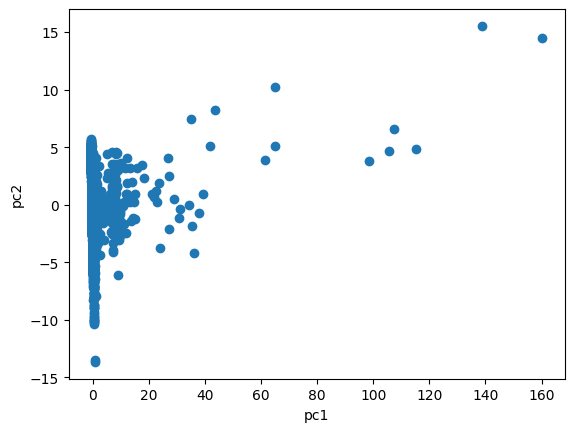

In [168]:
plt.scatter(pcom[:, 0], pcom[:, 1])
plt.xlabel('pc1')
plt.ylabel('pc2')
# plt.xscale('log')

In [64]:
pcom[:, 1]

array([ 0.38126829, -0.47728339,  1.89153481, ..., -1.79259133,
        0.34750034, -1.80213309])

In [177]:
Kmean = KMeans(n_clusters = 10)
Kmean.fit(pcom)

KMeans(n_clusters=10)

In [178]:
Kmean.cluster_centers_

array([[-2.28745045e-01,  1.60449580e+00],
       [ 2.83098521e-02, -1.68826601e+00],
       [ 1.49401265e+02,  1.50006558e+01],
       [-1.01359929e-01, -3.35986826e-02],
       [ 3.05935522e+01,  9.72150483e-01],
       [-3.65504276e-01,  3.38491487e+00],
       [ 1.61855096e-01, -3.59307005e+00],
       [ 9.07112748e+00,  1.93324975e-01],
       [ 6.38989367e+01,  6.38719966e+00],
       [ 1.06681788e+02,  4.95910149e+00]])

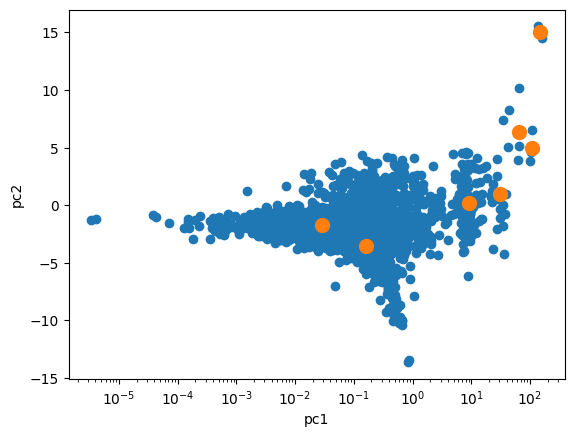

In [181]:
plt.scatter(pcom[:, 0], pcom[:, 1])
plt.scatter(Kmean.cluster_centers_[:, 0], 
            Kmean.cluster_centers_[:, 1],

            s=100)
plt.xlabel('pc1')
plt.ylabel('pc2')
# plt.xlim(-2,10)
plt.xscale('log')

In [142]:
pca_df = pd.DataFrame(pcom, columns=['pc1', 'pc2'])
pca_df

,pc1,pc2
0,-0.154500,0.381353
1,-0.107243,-0.477435
2,-0.229996,1.891602
3,-0.055585,-0.584898
4,-0.047862,-1.611736
...,...,...
23557,0.086636,-2.724660
23558,0.086634,-2.922515
23559,-0.003576,-1.792293
23560,-0.131768,0.347432


<Axes: >

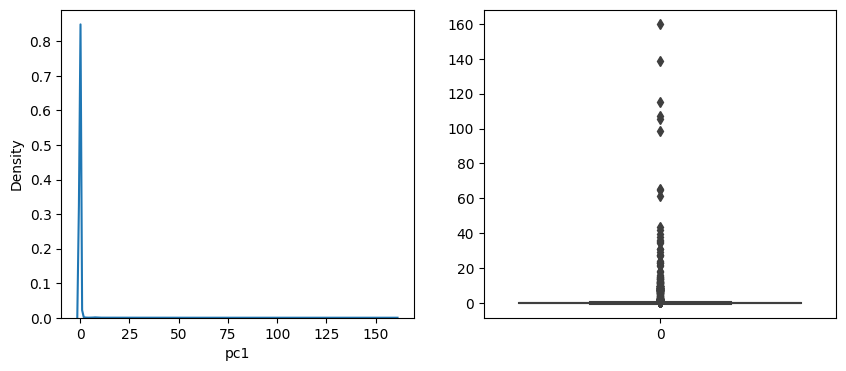

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(data=pca_df['pc1'], ax = ax[0])
sns.boxplot(data=pca_df['pc1'], ax = ax[1])


<Axes: >

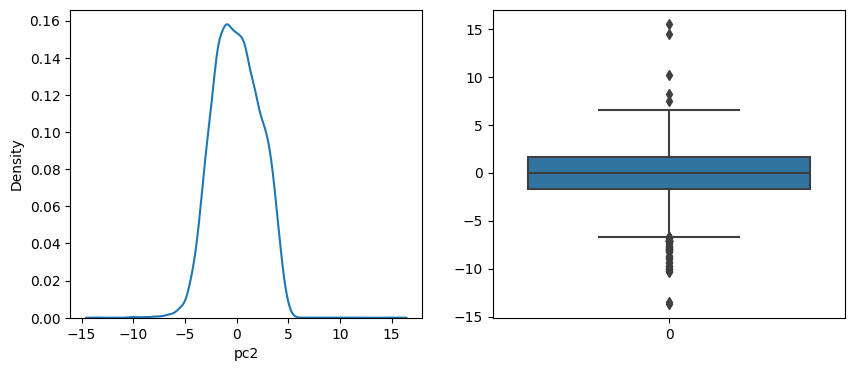

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.kdeplot(data=pca_df['pc2'], ax = ax[0])
sns.boxplot(data=pca_df['pc2'], ax = ax[1])


In [119]:
df1_kmeans = df1[FEATURES1].dropna(axis=1)
df1_kmeans['kmean_group'] = Kmean.labels_
df1_kmeans

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,room_coor_x_mean_,room_coor_y_mean_,screen_coor_x_mean_,screen_coor_y_mean_,elapsed_time_diff_mean_,room_coor_x_min_,room_coor_y_min_,screen_coor_x_min_,screen_coor_y_min_,room_coor_x_max_,room_coor_y_max_,screen_coor_x_max_,screen_coor_y_max_,elapsed_time_diff_max_,cutscene_click_ET_mean_,person_click_ET_mean_,navigate_click_ET_mean_,notification_click_ET_mean_,object_click_ET_mean_,map_click_ET_mean_,cutscene_click_ET_max_,person_click_ET_max_,navigate_click_ET_max_,notification_click_ET_max_,object_click_ET_max_,map_click_ET_max_,cutscene_click_ET_min_,person_click_ET_min_,navigate_click_ET_min_,notification_click_ET_min_,object_click_ET_min_,map_click_ET_min_,basic_ET_mean_,undefined_ET_mean_,close_ET_mean_,basic_ET_max_,undefined_ET_max_,close_ET_max_,basic_ET_min_,undefined_ET_min_,close_ET_min_,kmean_group
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,165,10,3,31,7,18,7.701275,-71.413749,93.550336,61.087248,1184.993939,-1013.383354,-307.773139,0.0,0.0,955.515258,416.026789,785.0,435.0,30837,970.714286,917.590909,904.172840,1821.750000,1799.000000,675.000000,2580,1774,2766,4540,4949,734,0,0,0,208,533,616,1507.486486,885.164706,1455.166667,30837,2766,2188,0,0,533,0
20090312433251036,139,11,4,23,6,12,-84.045960,-53.671082,90.788618,58.853659,1682.906475,-1112.320519,-518.582269,0.0,0.0,934.369987,441.012570,759.0,581.0,37409,1515.194444,1928.444444,1419.857143,1617.400000,810.733333,883.333333,8780,7984,7281,1833,1901,1283,0,203,352,1489,0,651,1959.116883,1356.303571,1014.000000,37409,7281,1114,0,268,901,0
20090312455206810,149,9,3,23,6,13,-209.830316,-31.125035,83.978723,37.510638,2450.959732,-1017.030893,-240.402154,0.0,0.0,875.079107,450.472504,1149.0,644.0,209421,601.938776,474.722222,4684.929825,2002.000000,881.800000,924.500000,5767,3785,209421,6354,2166,1501,0,199,0,383,248,348,1080.202381,4490.966667,999.600000,28744,209421,2021,0,0,248,0
20090313091715820,176,11,4,25,6,15,-111.962727,-76.698109,80.800000,72.443750,1110.056818,-995.609064,-431.727187,0.0,0.0,955.165697,455.432217,936.0,708.0,47849,688.147059,591.318182,839.962500,1298.000000,940.111111,1091.500000,4784,2050,8160,3301,3753,1651,0,0,0,0,199,532,1364.464286,879.729412,829.333333,47849,8160,1512,0,0,299,0
20090313571836404,112,10,4,23,6,13,-5.028427,-1.624746,180.690722,96.711340,1748.883929,-918.020665,-486.344229,0.0,0.0,880.694812,484.995333,836.0,558.0,31920,1415.615385,1230.578947,1532.457143,1648.500000,2242.777778,922.000000,3333,2751,4933,3684,8455,1600,0,732,0,700,433,549,1798.500000,1482.050000,2764.250000,31920,4933,8455,0,0,766,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,150,11,4,29,7,19,21.554218,-24.503885,130.875000,86.406250,3700.213333,-969.871826,-370.764352,0.0,0.0,865.163133,424.745879,774.0,531.0,76030,3324.551724,2899.809524,3298.637931,4826.888889,3828.538462,834.000000,8321,7721,28346,12591,16893,919,0,1368,0,1432,117,749,4056.933333,3079.134328,6233.571429,76030,28346,16893,0,0,1201,0
22100215460321130,149,11,4,26,7,17,26.882739,-53.245471,138.729323,115.699248,2392.261745,-994.022037,-438.979482,0.0,0.0,957.605762,435.382212,870.0,610.0,69407,2034.548387,1966.238095,1883.620000,2515.222222,1423.210526,1407.000000,3697,3357,5714,6484,6211,1698,0,75,0,1216,181,1116,2779.212500,1831.315789,2572.777778,69407,5714,8229,0,0,181,0
22100217104993650,197,10,4,28,7,17,-0.133792,-54.388004,145.114754,79.300546,2079.685279,-1024.681724,-463.847300,0.0,0.0,957.310401,475.225152,662.0,492.0,59853,1265.428571,2807.217391,1246.048077,1731.090909,2147.000000,4081.000000,3752,14765,4632,3828,11698,4797,0,237,217,0,83,3365,3089.000000,1317.486486,3160.222222,59853,4797,11698,0,217,802,0


In [120]:
df1_kmeans[df1_kmeans['kmean_group'] == 0]

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,room_coor_x_mean_,room_coor_y_mean_,screen_coor_x_mean_,screen_coor_y_mean_,elapsed_time_diff_mean_,room_coor_x_min_,room_coor_y_min_,screen_coor_x_min_,screen_coor_y_min_,room_coor_x_max_,room_coor_y_max_,screen_coor_x_max_,screen_coor_y_max_,elapsed_time_diff_max_,cutscene_click_ET_mean_,person_click_ET_mean_,navigate_click_ET_mean_,notification_click_ET_mean_,object_click_ET_mean_,map_click_ET_mean_,cutscene_click_ET_max_,person_click_ET_max_,navigate_click_ET_max_,notification_click_ET_max_,object_click_ET_max_,map_click_ET_max_,cutscene_click_ET_min_,person_click_ET_min_,navigate_click_ET_min_,notification_click_ET_min_,object_click_ET_min_,map_click_ET_min_,basic_ET_mean_,undefined_ET_mean_,close_ET_mean_,basic_ET_max_,undefined_ET_max_,close_ET_max_,basic_ET_min_,undefined_ET_min_,close_ET_min_,kmean_group
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,165,10,3,31,7,18,7.701275,-71.413749,93.550336,61.087248,1184.993939,-1013.383354,-307.773139,0.0,0.0,955.515258,416.026789,785.0,435.0,30837,970.714286,917.590909,904.172840,1821.750000,1799.000000,675.000000,2580,1774,2766,4540,4949,734,0,0,0,208,533,616,1507.486486,885.164706,1455.166667,30837,2766,2188,0,0,533,0
20090312433251036,139,11,4,23,6,12,-84.045960,-53.671082,90.788618,58.853659,1682.906475,-1112.320519,-518.582269,0.0,0.0,934.369987,441.012570,759.0,581.0,37409,1515.194444,1928.444444,1419.857143,1617.400000,810.733333,883.333333,8780,7984,7281,1833,1901,1283,0,203,352,1489,0,651,1959.116883,1356.303571,1014.000000,37409,7281,1114,0,268,901,0
20090312455206810,149,9,3,23,6,13,-209.830316,-31.125035,83.978723,37.510638,2450.959732,-1017.030893,-240.402154,0.0,0.0,875.079107,450.472504,1149.0,644.0,209421,601.938776,474.722222,4684.929825,2002.000000,881.800000,924.500000,5767,3785,209421,6354,2166,1501,0,199,0,383,248,348,1080.202381,4490.966667,999.600000,28744,209421,2021,0,0,248,0
20090313091715820,176,11,4,25,6,15,-111.962727,-76.698109,80.800000,72.443750,1110.056818,-995.609064,-431.727187,0.0,0.0,955.165697,455.432217,936.0,708.0,47849,688.147059,591.318182,839.962500,1298.000000,940.111111,1091.500000,4784,2050,8160,3301,3753,1651,0,0,0,0,199,532,1364.464286,879.729412,829.333333,47849,8160,1512,0,0,299,0
20090313571836404,112,10,4,23,6,13,-5.028427,-1.624746,180.690722,96.711340,1748.883929,-918.020665,-486.344229,0.0,0.0,880.694812,484.995333,836.0,558.0,31920,1415.615385,1230.578947,1532.457143,1648.500000,2242.777778,922.000000,3333,2751,4933,3684,8455,1600,0,732,0,700,433,549,1798.500000,1482.050000,2764.250000,31920,4933,8455,0,0,766,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,150,11,4,29,7,19,21.554218,-24.503885,130.875000,86.406250,3700.213333,-969.871826,-370.764352,0.0,0.0,865.163133,424.745879,774.0,531.0,76030,3324.551724,2899.809524,3298.637931,4826.888889,3828.538462,834.000000,8321,7721,28346,12591,16893,919,0,1368,0,1432,117,749,4056.933333,3079.134328,6233.571429,76030,28346,16893,0,0,1201,0
22100215460321130,149,11,4,26,7,17,26.882739,-53.245471,138.729323,115.699248,2392.261745,-994.022037,-438.979482,0.0,0.0,957.605762,435.382212,870.0,610.0,69407,2034.548387,1966.238095,1883.620000,2515.222222,1423.210526,1407.000000,3697,3357,5714,6484,6211,1698,0,75,0,1216,181,1116,2779.212500,1831.315789,2572.777778,69407,5714,8229,0,0,181,0
22100217104993650,197,10,4,28,7,17,-0.133792,-54.388004,145.114754,79.300546,2079.685279,-1024.681724,-463.847300,0.0,0.0,957.310401,475.225152,662.0,492.0,59853,1265.428571,2807.217391,1246.048077,1731.090909,2147.000000,4081.000000,3752,14765,4632,3828,11698,4797,0,237,217,0,83,3365,3089.000000,1317.486486,3160.222222,59853,4797,11698,0,217,802,0


In [121]:
df1_kmeans[df1_kmeans['kmean_group'] == 1]

,session_number_,event_name_unique_,name_unique_,fqid_unique_,room_fqid_unique_,text_fqid_unique_,room_coor_x_mean_,room_coor_y_mean_,screen_coor_x_mean_,screen_coor_y_mean_,elapsed_time_diff_mean_,room_coor_x_min_,room_coor_y_min_,screen_coor_x_min_,screen_coor_y_min_,room_coor_x_max_,room_coor_y_max_,screen_coor_x_max_,screen_coor_y_max_,elapsed_time_diff_max_,cutscene_click_ET_mean_,person_click_ET_mean_,navigate_click_ET_mean_,notification_click_ET_mean_,object_click_ET_mean_,map_click_ET_mean_,cutscene_click_ET_max_,person_click_ET_max_,navigate_click_ET_max_,notification_click_ET_max_,object_click_ET_max_,map_click_ET_max_,cutscene_click_ET_min_,person_click_ET_min_,navigate_click_ET_min_,notification_click_ET_min_,object_click_ET_min_,map_click_ET_min_,basic_ET_mean_,undefined_ET_mean_,close_ET_mean_,basic_ET_max_,undefined_ET_max_,close_ET_max_,basic_ET_min_,undefined_ET_min_,close_ET_min_,kmean_group
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21010518312983310,190,10,3,27,6,15,22.430988,-53.042346,65.805882,45.664706,2.115576e+06,-973.620223,-264.883220,0.0,0.0,868.529209,452.062593,757.0,479.0,401605298,1.636600e+03,2.113919e+07,8.110990e+02,2888.444444,5.114824e+03,616.00,5147,401605298,8370,8685,55407,850,0,700,0,481,2,382,5.286684e+06,8.830000e+02,1.100071e+04,401605298,10118,55407,0,0,1216,1
21030412532387650,158,11,4,26,6,16,-24.491784,-90.911310,116.979167,93.340278,3.817772e+06,-946.454501,-482.037352,0.0,0.0,975.055621,443.920774,820.0,561.0,602651269,2.153103e+07,1.256259e+03,3.402397e+03,1285.000000,1.395875e+03,2060.00,602651269,8116,126311,3031,2247,2632,0,0,0,223,793,1488,8.374249e+06,3.253959e+03,1.445889e+03,602651269,126311,2423,0,0,790,1
21040114240062616,291,10,3,24,7,15,-13.265597,-38.950972,76.715867,46.900369,3.437522e+06,-1021.255507,-361.753762,0.0,0.0,1066.112962,470.339413,801.0,561.0,1000000000,1.190521e+07,4.056977e+02,1.525804e+03,1178.095238,9.128000e+02,1093.75,1000000000,1750,39724,3514,2320,1814,0,0,0,201,0,547,5.953223e+06,1.460491e+03,1.266636e+03,1000000000,39724,2320,0,0,649,1
21040310404894990,112,9,3,21,6,13,77.154719,-32.677818,73.920000,39.050000,9.222369e+06,-1002.371547,-353.611939,0.0,0.0,938.674516,428.576980,710.0,541.0,513406465,1.439345e+03,1.366190e+03,2.518892e+07,3331.000000,3.915833e+03,1002.50,8944,5464,513406465,11095,14300,1131,0,0,0,1162,14,874,2.087548e+03,2.245116e+07,5.607500e+03,33644,513406465,14300,0,0,1315,1
21050314261588052,324,10,3,25,6,18,24.718527,-9.538018,60.959866,34.608696,1.868297e+06,-953.152250,-327.078042,0.0,0.0,936.709940,481.735568,773.0,491.0,605033811,7.858132e+06,5.128936e+02,8.543451e+02,1263.666667,1.284350e+03,1818.25,605033811,1558,4974,2547,2917,3092,0,0,0,0,143,1068,3.712758e+06,8.622715e+02,1.861300e+03,605033811,4974,2917,0,0,1252,1
21050411524141916,141,10,4,24,6,12,-26.440670,2.255434,91.421053,51.052632,2.516672e+06,-941.348234,-493.543557,0.0,0.0,846.552184,489.875731,784.0,551.0,354395889,6.681250e+02,6.867158e+03,3.798574e+03,682.500000,3.221889e+07,1419.50,3438,107565,160209,1774,354395889,1535,0,0,0,219,174,1304,3.002313e+03,3.635692e+03,5.063002e+07,107565,160209,354395889,0,0,1199,1
21110312203708684,184,10,4,23,6,13,143.466822,-12.486875,115.545977,78.511494,5.436491e+06,-978.796261,-464.287140,0.0,0.0,941.631808,478.481879,795.0,569.0,1000000000,1.492034e+03,1.086318e+03,2.272901e+07,1408.500000,1.184015e+03,973.50,7399,2300,1000000000,2351,10959,1917,0,0,0,714,0,30,1.661492e+03,2.040981e+07,2.606444e+03,54680,1000000000,5072,0,0,1232,1
22000410231856948,282,11,4,26,6,15,-3.479429,-36.613206,85.193676,50.446640,3.549091e+06,-946.261420,-437.938172,0.0,0.0,1015.764712,447.542970,799.0,562.0,1000000000,1.538730e+07,2.687243e+03,1.306593e+03,4706.800000,5.645533e+03,1115.80,1000000000,5473,7041,8465,19579,2882,0,999,0,2549,851,102,7.411498e+06,1.345121e+03,8.799667e+03,1000000000,7782,33156,0,0,899,1
22090510463732496,435,11,4,27,7,17,-12.903144,-50.251714,80.004890,47.063570,2.300794e+06,-1181.499354,-45